<a href="https://colab.research.google.com/github/Machine-Learning-Robot-Competition/data/blob/main/Letter_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Environment

(only run once!)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Setup Dependencies

(only run once!)

In [ ]:
!pip install tensorflow==2.13.1
!pip install keras==2.13.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 25.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found exist

## Setup Directories

Ensure that these folders exist!

In [ ]:
letter_dir = "/content/drive/MyDrive/ENPH353/letters"
model_dir = "/content/drive/MyDrive/ENPH353/models"

## Prepare for Pipeline

Definitions and declarations

In [2]:
import numpy as np
import re
import concurrent.futures
import cv2
import string
import random
import os

encoding = {
    "A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "H": 7, "I": 8, "J": 9,
    "K": 10, "L": 11, "M": 12, "N": 13, "O": 14, "P": 15, "Q": 16, "R": 17, "S": 18,
    "T": 19, "U": 20, "V": 21, "W": 22, "X": 23, "Y": 24, "Z": 25
}


reversed_encoding = {value: key for key, value in encoding.items()}


def identifier(letter: str):
  return encoding[letter]


def generate_random_string(length=7):
  characters = string.ascii_lowercase + string.digits  # Letters + digits
  return ''.join(random.choice(characters) for _ in range(length))


def get_letter_dir(letter: str):
  return os.path.join(letter_dir, str(identifier(letter)))


def convert_to_one_hot(Y, C):
  Y = np.eye(C)[Y.reshape(-1)]
  return Y

## Extract

Extract all data (using over-engineered concurrent IO) from Google Drive

In [3]:
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict
import cv2

# Function to load images in a subdirectory
def load_images_from_subdir(subdir_path):
    images = []
    for filename in os.listdir(subdir_path):
        if filename.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):
            image_path = os.path.join(subdir_path, filename)
            try:
                image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_RGB2GRAY)

                images.append(image)
            except Exception as e:
                print(f"Error loading {image_path}: {e}")
    return images

# Function to process the directory and load images in parallel
def load_images_in_parallel(directory):
    subdirectories = [os.path.join(directory, subdir) for subdir in os.listdir(directory)
                      if os.path.isdir(os.path.join(directory, subdir))]

    images_dict = defaultdict(list)

    # Using ThreadPoolExecutor to parallelize image loading
    with ThreadPoolExecutor() as executor:
        # Map each subdirectory to the load_images_from_subdir function
        results = executor.map(load_images_from_subdir, subdirectories)

        # Populate the dictionary with the results
        for subdir, images in zip(subdirectories, results):
            subdir_name = os.path.basename(subdir)
            images_dict[subdir_name] = images

    return images_dict

images_dict = load_images_in_parallel(letter_dir)

# Print the dictionary to verify
for subdir, images in images_dict.items():
    print(f"Directory '{subdir}' contains {len(images)} images.")

Directory '0' contains 60 images.
Directory '1' contains 20 images.
Directory '2' contains 20 images.
Directory '3' contains 60 images.
Directory '4' contains 30 images.
Directory '5' contains 40 images.
Directory '6' contains 20 images.
Directory '7' contains 20 images.
Directory '8' contains 20 images.
Directory '9' contains 20 images.
Directory '10' contains 10 images.
Directory '11' contains 15 images.
Directory '12' contains 15 images.
Directory '13' contains 20 images.
Directory '14' contains 30 images.
Directory '15' contains 30 images.
Directory '16' contains 30 images.
Directory '17' contains 20 images.
Directory '18' contains 20 images.
Directory '19' contains 20 images.
Directory '20' contains 20 images.
Directory '21' contains 30 images.
Directory '22' contains 30 images.
Directory '23' contains 10 images.
Directory '24' contains 10 images.
Directory '25' contains 20 images.


# Dataset Preparation

In [4]:
import math
import random


Y_dataset_raw = []
X_dataset_raw = []

# Organize every letter into the format (letter, letter_image) so that we can
# shuffle the list without messing up the labels
pair_list = []
for label, images in images_dict.items():
  for image in images:
    pair_list.append((int(label), image))
random.shuffle(pair_list)

# Populate the datasets with shuffled data
for pair in pair_list:
  label, image = pair

  Y_dataset_raw.append(label)
  X_dataset_raw.append(image)


X_dataset = np.array(X_dataset_raw)
Y_dataset = convert_to_one_hot(np.array(Y_dataset_raw), len(encoding.values()))

# Now, perform a train/validation set split
VALIDATION_SPLIT = 0.2

split_index = math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT))

X_train_dataset = X_dataset[:split_index]
Y_train_dataset = Y_dataset[:split_index]

X_val_dataset = X_dataset[split_index:]
Y_val_dataset = Y_dataset[split_index:]

x_width, y_width = X_train_dataset[0].shape

# Training

Create the network and train it

In [5]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [7]:
print((x_width, y_width, 1))

(40, 35, 1)


In [6]:
from tensorflow.keras import models, layers, losses, optimizers, callbacks

convolution_model = models.Sequential()
convolution_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(x_width, y_width, 1)))
convolution_model.add(layers.MaxPooling2D((3, 3)))
convolution_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
convolution_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
convolution_model.add(layers.MaxPooling2D((2, 2)))
convolution_model.add(layers.Flatten())
convolution_model.add(layers.Dropout(0.50))
convolution_model.add(layers.Dense(512, activation='relu'))
convolution_model.add(layers.Dropout(0.50))
convolution_model.add(layers.Dense(512, activation='relu'))
convolution_model.add(layers.Dense(len(encoding.keys()), activation='softmax'))

convolution_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 38, 33, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 9, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 26)                  │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,219,034 (8.46 MB)

 Trainable params: 2,219,034 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
LEARNING_RATE = 1.75e-4
convolution_model.compile(loss=losses.CategoricalCrossentropy(),
                          optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                          metrics=['acc'])

In [ ]:
reset_weights(convolution_model)

callback = callbacks.EarlyStopping(monitor='val_loss', patience=5)

history_conv = convolution_model.fit(X_train_dataset, Y_train_dataset,
                                    validation_data=(X_val_dataset, Y_val_dataset),
                                    callbacks=[callback],
                                    epochs=40,
                                    batch_size=16)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


32/32 [==============================] - 5s 149ms/step - loss: 9.3447 - acc: 0.2559 - val_loss: 0.6775 - val_acc: 0.7891
Epoch 2/40
32/32 [==============================] - 4s 133ms/step - loss: 1.7586 - acc: 0.5703 - val_loss: 0.1952 - val_acc: 0.8906
Epoch 3/40
32/32 [==============================] - 4s 126ms/step - loss: 1.0271 - acc: 0.7324 - val_loss: 0.0824 - val_acc: 0.9609
Epoch 4/40
32/32 [==============================] - 4s 133ms/step - loss: 0.5469 - acc: 0.8340 - val_loss: 0.2737 - val_acc: 0.9531
Epoch 5/40
32/32 [==============================] - 4s 136ms/step - loss: 0.4623 - acc: 0.8750 - val_loss: 0.1211 - val_acc: 0.9531
Epoch 6/40
32/32 [==============================] - 4s 130ms/step - loss: 0.4039 - acc: 0.9004 - val_loss: 0.0491 - val_acc: 1.0000
Epoch 7/40
32/32 [==============================] - 4s 132ms/step - loss: 0.3334 - acc: 0.9219 - val_loss: 0.3060 - val_acc: 0.9609
Epoch 8/40
32/32 [==============================] - 4s 135ms/step - loss: 0.3174 - acc:

# Inspect results

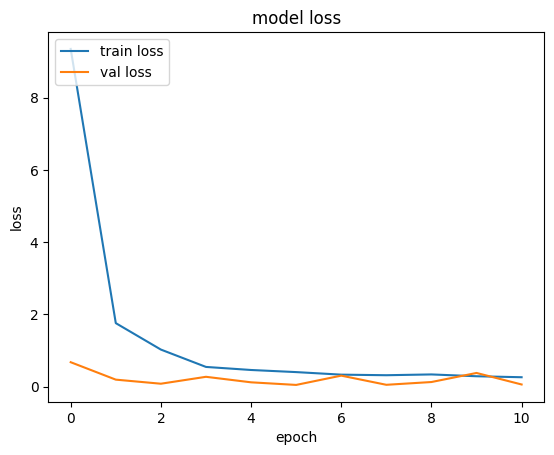

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

In [8]:
print(X_val_dataset[2].shape)

(40, 35)


1/1 [==============================] - 0s 30ms/step
Network says: R


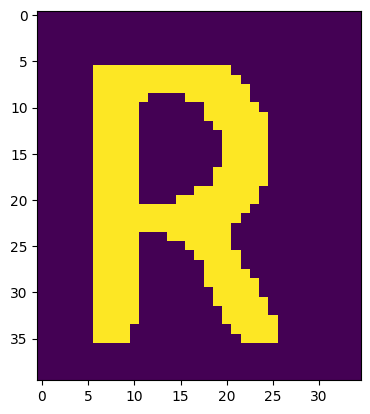

In [ ]:
i = 32

def predict(X_data, model):
  input_data = np.expand_dims(X_data, axis=0)
  result = model.predict(input_data)
  return reversed_encoding[np.argmax(result[0])]

example = X_val_dataset[i]
print(f"Network says: {predict(example, convolution_model)}").
plt.imshow(example)

In [ ]:
y_pred_test = [predict(plate, convolution_model) for plate in X_val_dataset]
y_true = [reversed_encoding[np.argmax(y)] for y in Y_val_dataset]

1/1 [==============================] - 0s 23ms/step


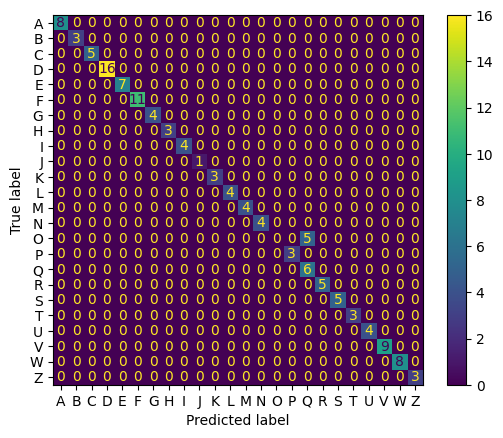

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true, y_pred_test)
plt.show()

# Save the model
with a random name

In [ ]:
convolution_model.save(f'{model_dir}/{generate_random_string()}.keras')